# CNN MobileNet V2

Ce modèle avancée de Deep Learning utilise le modèle [MobileNet V2](https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2) pour prédire la catégorie des images.

## Setup

La cellule ci-dessous permet de définir les constantes du projet.

In [1]:
import os
import datetime

# Define our images size
IMG_SIZE = 224
# Number of categories we have
NO_OF_OUTPUT_CLASSES = 27
# Batch size used during training and seed for shuffling
BATCH_SIZE = 96
SEED = 12345

# True to add data augmentation layers
DO_DATA_AUGMENTATION = True

# Define if we are running the model locally or on Google Colab
# This allow the usage af all the RAM available locally, but not
# on Colab to avoid crashes.
# True for local run, False for Google Colab
IS_LOCAL = True

if IS_LOCAL:
    import src.data.data as data

    # Image input directories
    TRAIN_DIR = data.get_output_dir(IMG_SIZE, IMG_SIZE, True, False, "train")
    TEST_DIR = data.get_output_dir(IMG_SIZE, IMG_SIZE, True, False, "test")

    # Checkpoint directory and paths
    CHECKPOINT_DIR = os.path.join(
        "data", "models", "cnn_mobilenetv2")
    CHECKPOINT_PATH = os.path.join(
        CHECKPOINT_DIR, "cp_{val_loss:.2f}-{val_accuracy:.2f}-.ckpt")

    # Path to the history CSV file to store training metrics
    HIST_CSV_PATH = os.path.join(CHECKPOINT_DIR, "history.csv")

    # Define where to store training logs
    LOG_DIR = os.path.join(CHECKPOINT_DIR, "logs", "fit")
    LOG_DATA = os.path.join(
        LOG_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

    # Contants used only for image generation
    # Define the dataset size
    TRAIN_SIZE = 0.8
    TEST_SIZE = 0.2
    # Number of threads to use with images conversion
    NB_THREADS = 16

else:
    PATH_TO_IMG_ZIP = "/content/drive/MyDrive/fev23_bds_rakuten/Modèles/cropped_w224_h224_ratio_colors.zip"

    TRAIN_DIR = "/content/data/images/cropped_w224_h224_ratio_colors/train"
    TEST_DIR = "/content/data/images/cropped_w224_h224_ratio_colors/test"

    CHECKPOINT_DIR = "/content/drive/MyDrive/fev23_bds_rakuten/Modèles/cnn_mobilenetv2/"
    CHECKPOINT_PATH = CHECKPOINT_DIR + \
        "cp_{val_loss:.2f}-{val_accuracy:.2f}-.ckpt"

    HIST_CSV_PATH = CHECKPOINT_DIR + "history.csv"

    # Define where to store training logs
    LOG_DIR = os.path.join(CHECKPOINT_DIR, "logs", "fit")
    LOG_DATA = os.path.join(
        LOG_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


### Génération des jeux de données

Par défaut, les images sont de taille 500x500 et dans un seul dossier. Nous faisons un prétraitement dessus pour retirer au maximum les bandes blanches autours et les catégoriser dans des dossiers. C'est le rôle du code ci-dessous.

In [6]:
if IS_LOCAL:
    import os
    import src.data.data as data
    import importlib
    from src.data import transformer
    from sklearn.model_selection import train_test_split

    importlib.reload(transformer)
    importlib.reload(data)

    df = data.load_data()
    target = df["prdtypecode"]
    features = df.drop("prdtypecode", axis=1)

    X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                        train_size=TRAIN_SIZE,
                                                        test_size=TEST_SIZE)

    transformer = transformer.ImagePipeline(width=IMG_SIZE, height=IMG_SIZE,
                                            keep_ratio=True,
                                            grayscale=False,
                                            nb_threads=NB_THREADS)

    img_output_dir = transformer.output_dir.split('/')[1]

    print("Transformation du jeu de données d'entrainement")
    transformer.img_transformer.transform(X=X_train, y=y_train, type="train")
    print("Transformation du jeu de données de test")
    transformer.img_transformer.transform(X=X_test, y=y_test, type="test")

else:
    from google.colab import drive
    drive.mount('/content/drive')

    import zipfile

    with zipfile.ZipFile(PATH_TO_IMG_ZIP, 'r') as zip_ref:
        zip_ref.extractall(".")


Avancement : 100%


## Chargement des jeux de données et déclaration de la couche d'augmentation

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

if "2.9" in tf.version.VERSION:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        validation_split=0.2,
        subset="training",
        seed=SEED,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode="categorical")

    val_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        validation_split=0.2,
        subset="validation",
        seed=SEED,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode="categorical")
else:
    (train_ds, val_ds) = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        validation_split=0.2,
        subset="both",
        seed=SEED,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode="categorical")

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical")

if DO_DATA_AUGMENTATION:
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomTranslation(
            height_factor=(-0.2, 0.3), width_factor=(-0.2, 0.3))
    ])
else:
    data_augmentation = tf.keras.Sequential([])

if IS_LOCAL:
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 67932 files belonging to 27 classes.
Using 54346 files for training.
Using 13586 files for validation.
Found 16984 files belonging to 27 classes.


## Entrainement

Chargement et compilation du modèle.

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, TensorBoard
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.train import latest_checkpoint
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential, regularizers

# Tensorflow supports GPU on Windows until version 2.10
# However, this version produces a lot of warning when using
# data augmentation layer. Also, we have different imports
if ("2.10" in tf.version.VERSION):
    print("Running Tensorflow 2.10, set logging to errors only to avoid warning message flooding from data augmentation layers.")
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    from tensorflow.keras.optimizers import SGD
elif ("2.9" in tf.version.VERSION):
    print("Running Tensorflow 2.9")
    from tensorflow.keras.optimizers import SGD
else:
    print(f"Running {tf.version.VERSION}")
    from tensorflow.keras.optimizers.legacy import SGD

# Download mobilenet model from tensorflow hub
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
mobilenet_layers = hub.KerasLayer(URL,
                                  input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                  trainable=True)

model = Sequential([
    layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    data_augmentation,
    layers.Rescaling(1./255),
    mobilenet_layers,
    layers.Dropout(rate=0.2),
    layers.Dense(NO_OF_OUTPUT_CLASSES,
                 kernel_regularizer=regularizers.l2(0.0001))
])

model.build((None, IMG_SIZE, IMG_SIZE, 3))
model.compile(
    optimizer=SGD(learning_rate=0.005, momentum=0.9),
    loss=CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
    metrics=['accuracy'])


latest = latest_checkpoint(CHECKPOINT_DIR)
if (latest is not None):
    print("Loading checkpoint", latest)
    model.load_weights(latest)
else:
    print("No checkpoint to load")

# Callbacks called between each epoch
cp_callbacks = [
    # Stop the training when there is no improvement in val_accuracy for 3 epochs
    EarlyStopping(monitor='val_accuracy', patience=3),
    # Save a checkpoint
    ModelCheckpoint(CHECKPOINT_PATH,
                    save_best_only=True,
                    mode="max",
                    monitor="val_accuracy",
                    save_weights_only=True,
                    verbose=1),
    # Insert the metrics into a CSV file
    CSVLogger(HIST_CSV_PATH, separator=',', append=True),
    # Log information to display them in TensorBoard
    TensorBoard(log_dir=LOG_DIR, histogram_freq=1)
]

# The numbers bellow were found following the execution of the previous cell. Somehow, I didn't find a way to store them in a variable without going through the whole data set.
steps_per_epoch = 54346 // BATCH_SIZE
validation_steps = 13586 // BATCH_SIZE

model.summary()


Running Tensorflow 2.10, set logging to errors only to avoid warning message flooding from data augmentation layers.
Loading checkpoint data\models\cnn_mobilenetv2_retrained\cp_1.92-0.57-.ckpt
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     multiple                  0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 27)                34587     
                                                           

In [5]:
model.fit(
    train_ds.repeat(),
    epochs=100, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds.repeat(),
    validation_steps=validation_steps,
    callbacks=cp_callbacks)


Epoch 1/100
566/566 [==============================] - ETA: 0s - loss: 1.5484 - accuracy: 0.6974
Epoch 1: val_accuracy improved from -inf to 0.61059, saving model to data\models\cnn_mobilenetv2_retrained\cp_1.82-0.61-.ckpt
566/566 [==============================] - 374s 646ms/step - loss: 1.5484 - accuracy: 0.6974 - val_loss: 1.8244 - val_accuracy: 0.6106
Epoch 2/100
566/566 [==============================] - ETA: 0s - loss: 1.3281 - accuracy: 0.7914
Epoch 2: val_accuracy improved from 0.61059 to 0.61872, saving model to data\models\cnn_mobilenetv2_retrained\cp_1.85-0.62-.ckpt
566/566 [==============================] - 669s 1s/step - loss: 1.3281 - accuracy: 0.7914 - val_loss: 1.8485 - val_accuracy: 0.6187
Epoch 3/100
566/566 [==============================] - ETA: 0s - loss: 1.1691 - accuracy: 0.8636
Epoch 3: val_accuracy did not improve from 0.61872
566/566 [==============================] - 584s 1s/step - loss: 1.1691 - accuracy: 0.8636 - val_loss: 1.9326 - val_accuracy: 0.6128
Epoc

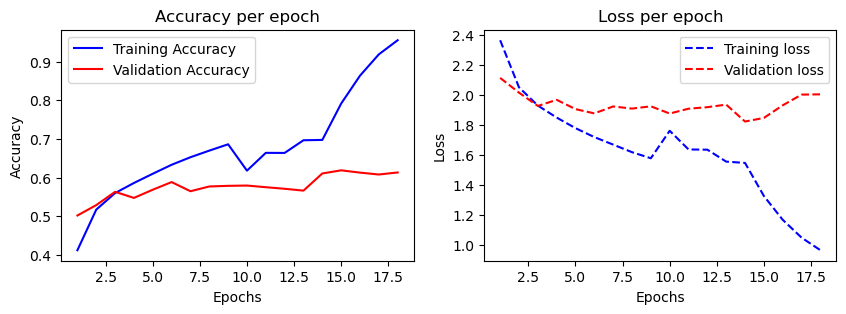

In [10]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

training_history = pd.read_csv(HIST_CSV_PATH, delimiter=",", header=0)

fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_subplot(121)

# Labels des axes
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
ax1.plot(np.arange(1, training_history["accuracy"].count() + 1, 1),
         training_history["accuracy"],
         label='Training Accuracy',
         color='blue')

# Courbe de la précision sur l'échantillon de test
ax1.plot(np.arange(1, training_history["val_accuracy"].count() + 1, 1),
         training_history['val_accuracy'],
         label='Validation Accuracy',
         color='red')

ax1.legend()
ax1.set_title("Accuracy per epoch")

ax2 = fig.add_subplot(122)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')

ax2.plot(np.arange(1, training_history["loss"].count() + 1, 1),
         training_history['loss'],
         label='Training loss',
         linestyle="dashed",
         color='blue')

ax2.plot(np.arange(1, training_history["val_loss"].count() + 1, 1),
         training_history['val_loss'],
         label='Validation loss',
         linestyle="dashed",
         color='red')

ax2.legend()
ax2.set_title("Loss per epoch")

# Affichage de la figure
plt.show()


## Prédictions de la catégorie des images du jeu de test

In [11]:
import numpy as np
from IPython.display import clear_output

predictions = np.array([])
labels = np.array([])
for x, y in test_ds:
    predictions = np.concatenate(
        [predictions, np.argmax(model.predict(x, verbose=0), axis=-1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

clear_output(wait=True)
print("Done")


Done


## Affichage du rapport de classification

In [12]:
from sklearn import metrics

prdtypecodes = sorted([int(x) for x in os.listdir(TEST_DIR)])

test_labels = [prdtypecodes[int(i)] for i in labels]
predictions_labels = [prdtypecodes[int(i)] for i in predictions]

print("Score accuracy :", metrics.accuracy_score(
    test_labels, predictions_labels), "\n\n")
print(metrics.classification_report(test_labels, predictions_labels))


Score accuracy : 0.6115167216203485 


              precision    recall  f1-score   support

          10       0.64      0.49      0.55       634
          40       0.62      0.64      0.63       524
          50       0.90      0.93      0.91       812
          60       0.36      0.46      0.40       155
        1140       0.40      0.37      0.39       968
        1160       0.26      0.23      0.24       394
        1180       0.74      0.61      0.66       998
        1280       0.63      0.62      0.63       163
        1281       0.37      0.45      0.41       498
        1300       0.50      0.39      0.44       659
        1301       0.54      0.55      0.54       965
        1302       0.79      0.75      0.77       879
        1320       0.62      0.64      0.63       152
        1560       0.46      0.51      0.48       997
        1920       0.54      0.31      0.40       160
        1940       0.77      0.71      0.74       907
        2060       0.59      0.66      0.6

## Affichage de la matrice de confusion

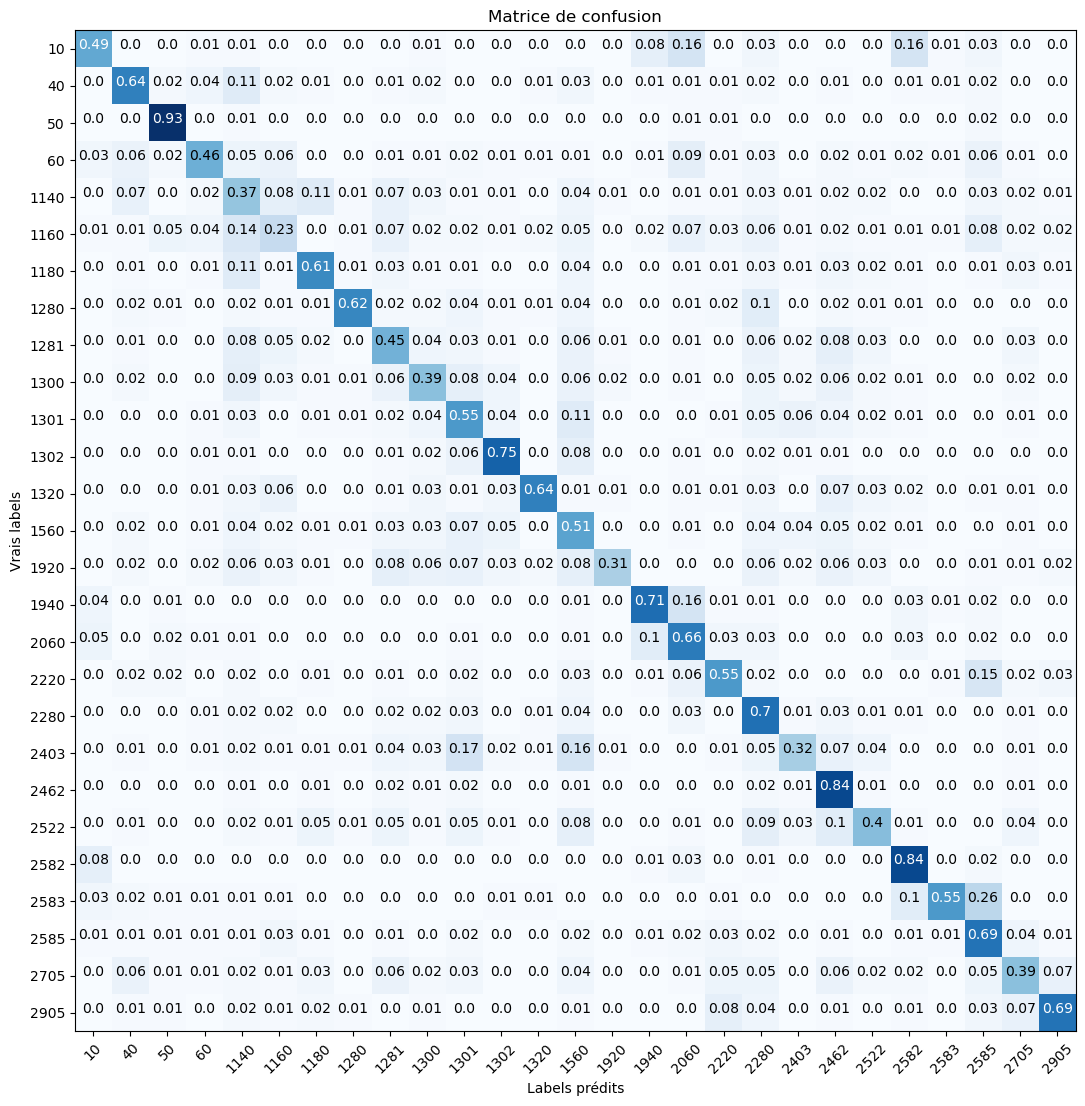

In [13]:
import itertools
from matplotlib import pyplot as plt


cnf_matrix = np.round(metrics.confusion_matrix(
    test_labels, predictions_labels, normalize="true"), 2)

classes = range(0, NO_OF_OUTPUT_CLASSES)

plt.figure(figsize=(13, 13))

plt.imshow(cnf_matrix, interpolation='nearest', cmap='Blues')
plt.title("Matrice de confusion")
tick_marks = classes
plt.xticks(tick_marks, prdtypecodes)
plt.yticks(tick_marks, prdtypecodes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > (cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.xticks(rotation=45)
plt.show()
